In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

In [2]:
from research.strings import VIOLATIONS, MONTHS

In [3]:
def show_hit_rate_boxplots(box_df, label=None, yticks=None):
    name_list = box_df["name"].unique()
    pal = sns.color_palette("hls", len(name_list))
    sns.boxplot(x="violation", y="rate", hue="name", palette=pal, data=box_df)
    if yticks is not None:
        plt.yticks(yticks)
    plt.xlabel("Violation Code")
    plt.ylabel("Monthly Hit Rate")
    if label is not None:
        plt.title("{}: Box Plots of Critical Violation Monthly Hit Rates Before and After 2015".format(label))
    else:
        plt.title("Box Plots of Critical Violation Monthly Hit Rates Before and After 2015")  
    plt.grid(linestyle="--")
    plt.gcf().set_size_inches(14, 8)
    plt.show()

In [4]:
def make_hit_rate_boxplots(raw, label=None, yticks=None):
    df = raw.query("year < 2018")
    print("Kept {} records.".format(len(df)))
    print("Date Range: {} to {}".format(df["date_str"].min(), df["date_str"].max()))
    df_before = df.query("year < 2015")
    df_after = df.query("year >= 2015")
    name_list = ["Before Model", "After Model"]
    df_list = [df_before, df_after]
    print("Found {} records before model deployment.".format(len(df_before)))
    print("Found {} records after model deployment.".format(len(df_after)))
    records = []
    for viol in VIOLATIONS:
        for ser, name in zip(df_list, name_list):
            rates = list(ser.groupby("month")[viol].mean().values)
            for rate in rates:
                records.append({
                    "rate": rate,
                    "name": name,
                    "violation": viol
                })
    box_df = pd.DataFrame(records)
    print("Expected: {} = {} records, Got: {} records".format(
        "{} x {} x {}".format(len(VIOLATIONS), len(MONTHS), len(df_list)),
        len(VIOLATIONS) * len(MONTHS) * len(df_list),
        len(box_df)
    ))
    show_hit_rate_boxplots(box_df, label, yticks)
    return box_df

In [5]:
all_canvass = pd.read_csv("data/canvass_records.csv.gz")
all_complaint = pd.read_csv("data/complaint_records.csv.gz")
print("Read {} canvass records.".format(len(all_canvass)))
print("Read {} complaint records.".format(len(all_complaint)))

Read 50462 canvass records.
Read 17088 complaint records.


In [6]:
yticks = np.arange(0.0, 0.20, 0.01)

Kept 47639 records.
Date Range: 2010-01-04 to 2017-12-29
Found 27277 records before model deployment.
Found 20362 records after model deployment.
Expected: 14 x 12 x 2 = 336 records, Got: 336 records


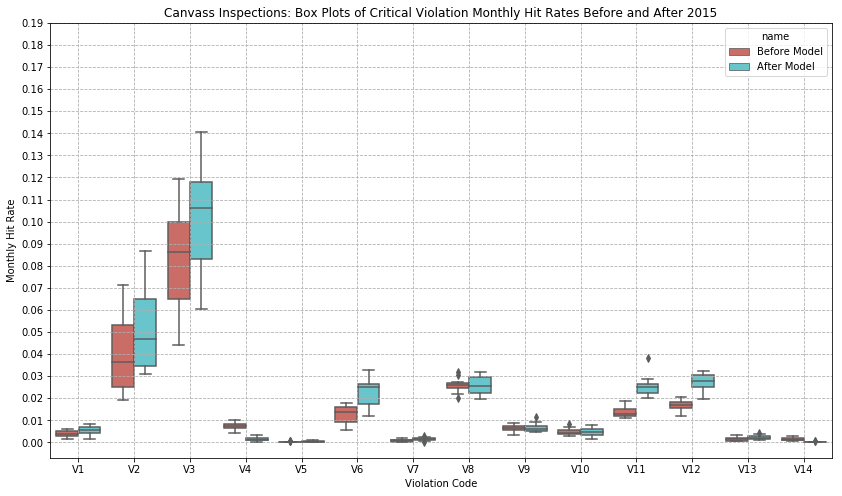

In [7]:
box_canvass = make_hit_rate_boxplots(all_canvass, label="Canvass Inspections", yticks=yticks)

Kept 16083 records.
Date Range: 2010-01-05 to 2017-12-29
Found 10053 records before model deployment.
Found 6030 records after model deployment.
Expected: 14 x 12 x 2 = 336 records, Got: 336 records


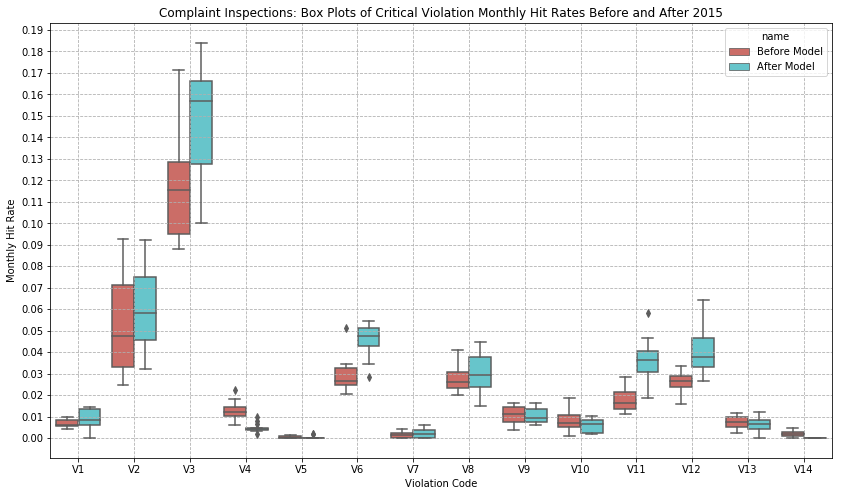

In [8]:
box_complaint = make_hit_rate_boxplots(all_complaint, label="Complaint Inspections", yticks=yticks)

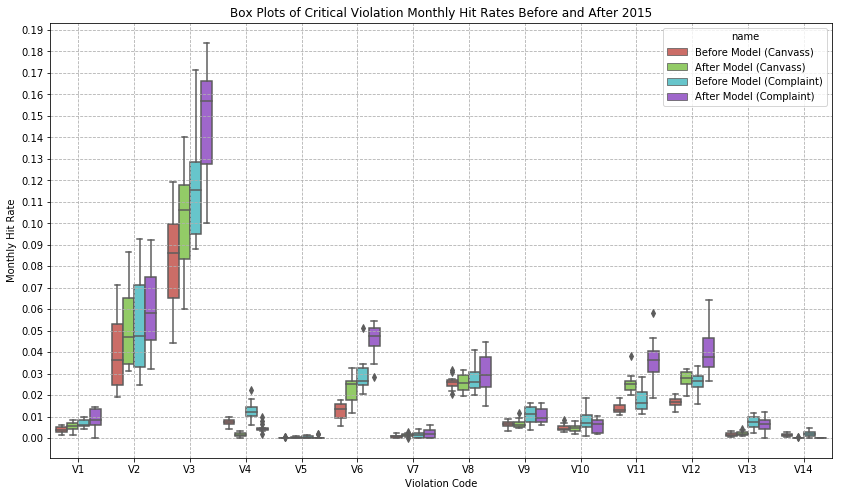

In [9]:
box_canvass["name"] = box_canvass["name"].apply(lambda n: n + " (Canvass)")
box_complaint["name"] = box_complaint["name"].apply(lambda n: n + " (Complaint)")
box_all = pd.concat([box_canvass, box_complaint])
show_hit_rate_boxplots(box_all, yticks=yticks)

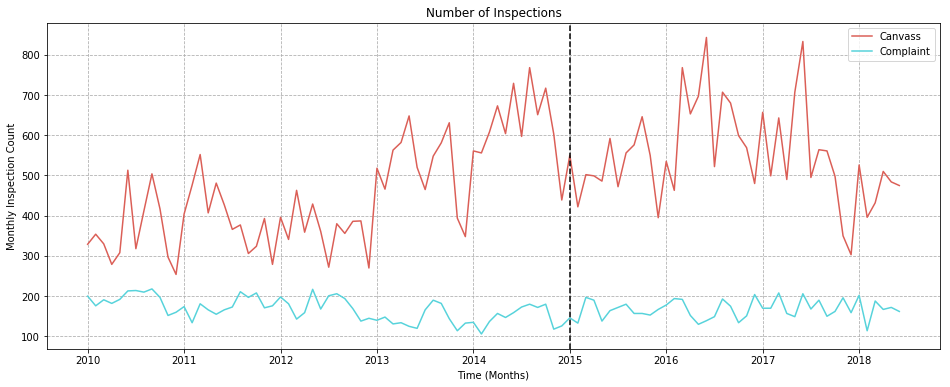

In [21]:
pal = sns.color_palette("hls", 2)
count_canvass = all_canvass.groupby("year_month")["inspection_id"].count()
count_complaint = all_complaint.groupby("year_month")["inspection_id"].count()
sns.lineplot(x=count_canvass.index, y=count_canvass.values, label="Canvass", color=pal[0])
sns.lineplot(x=count_complaint.index, y=count_complaint.values, label="Complaint", color=pal[1])
plt.axvline("2015-01", color="black", linestyle="--")
n_year_months = len(all_complaint["year_month"].unique())
min_year = all_complaint["year"].min()
max_year = all_complaint["year"].max()
plt.xticks(range(0, n_year_months, 12), range(min_year, max_year + 1))
plt.xlabel("Time (Months)")
plt.ylabel("Monthly Inspection Count")
plt.title("Number of Inspections")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(16, 6)
plt.show()

In [10]:
def make_year_month(df):
    return ["{0}-{1:02}".format(c["year"], c["month"]) for c in df.to_dict(orient="records")]

In [11]:
def show_hit_rate_lineplot(df_canvass, df_complaint, col, label=None):
    pal = sns.color_palette("hls", 2)
    rates_canvass = df_canvass.groupby("year_month")[col].mean()
    sns.lineplot(rates_canvass.index, rates_canvass.values, label="Canvass", color=pal[0])
    rates_complaint = df_complaint.groupby("year_month")[col].mean()
    sns.lineplot(rates_complaint.index, rates_complaint.values, label="Complaint", color=pal[1])
    plt.axvline("2015-01", color="black", linestyle="--")
    n_year_months = len(all_canvass["year_month"].unique())
    min_year = all_canvass["year"].min()
    max_year = all_canvass["year"].max()
    plt.xticks(range(0, n_year_months, 12), range(min_year, max_year + 1))
    plt.xlabel("Time (Months)")
    plt.ylabel("Monthly Hit Rate")
    if label is not None:
        plt.title(label)
    else:
        plt.title("{}".format(col))
    plt.grid(linestyle="--")
    plt.gcf().set_size_inches(16, 6)
    plt.show()

In [12]:
all_canvass["year_month"] = make_year_month(all_canvass)
all_complaint["year_month"] = make_year_month(all_complaint)
all_canvass["critical_found"] = all_canvass[VIOLATIONS].max(axis=1)
all_complaint["critical_found"] = all_complaint[VIOLATIONS].max(axis=1)

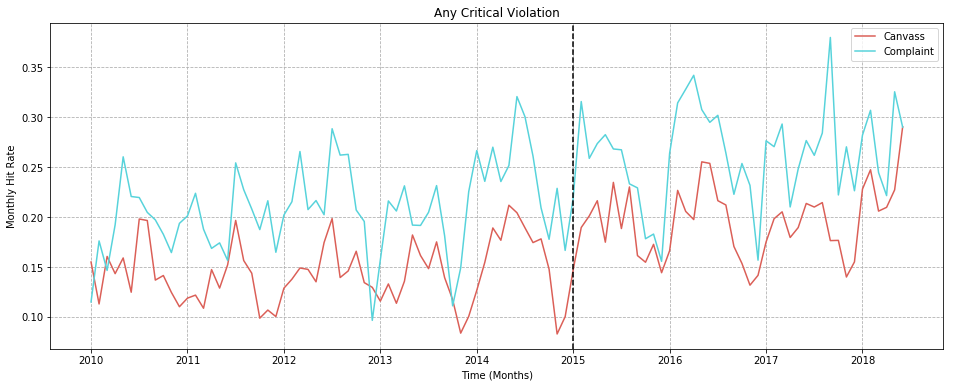

In [13]:
show_hit_rate_lineplot(all_canvass, all_complaint, "critical_found", label="Any Critical Violation")

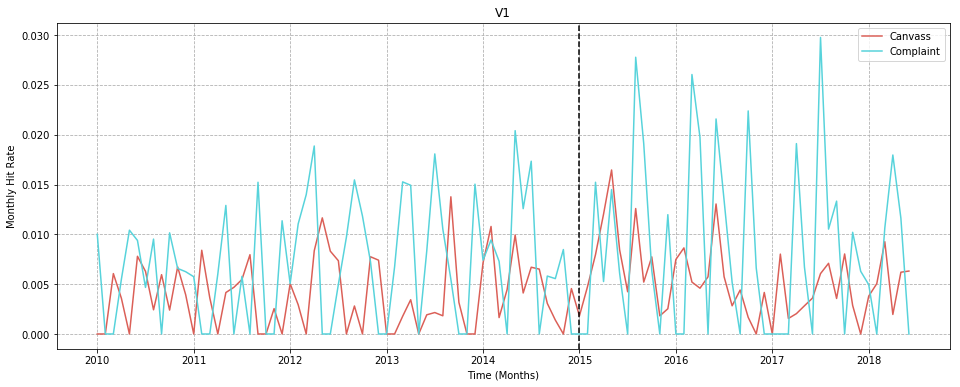

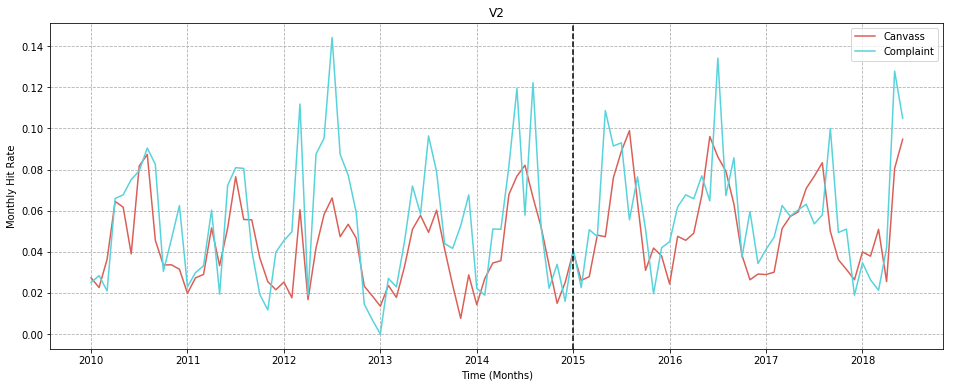

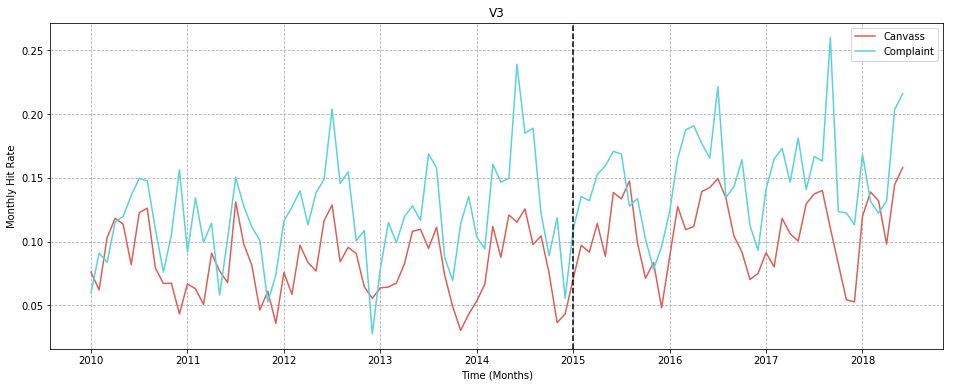

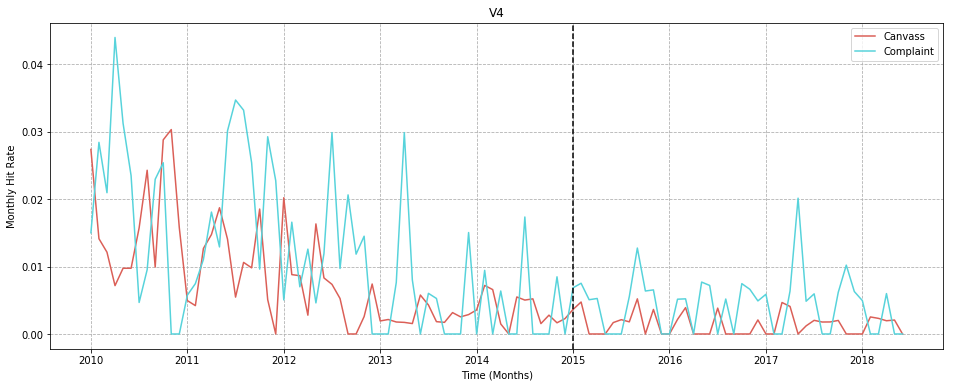

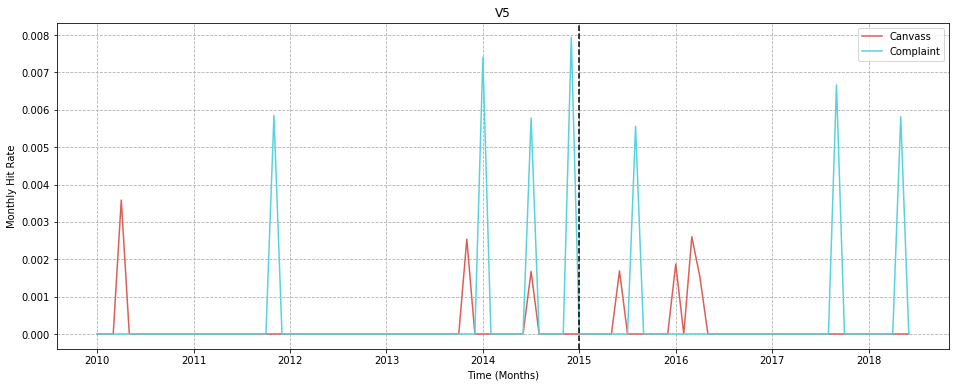

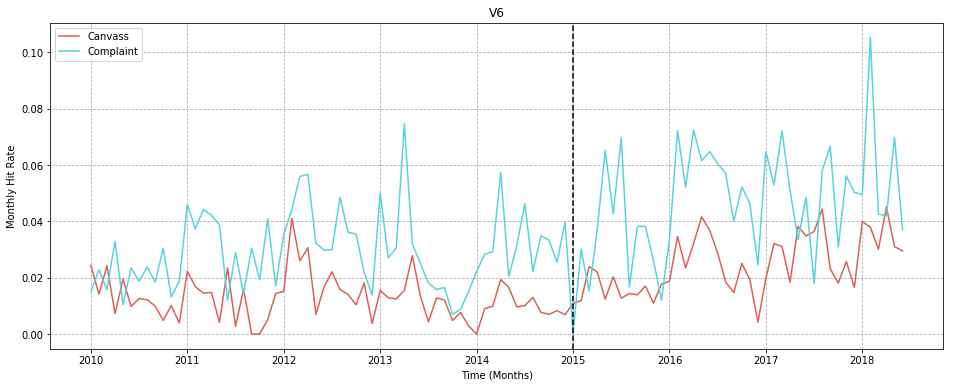

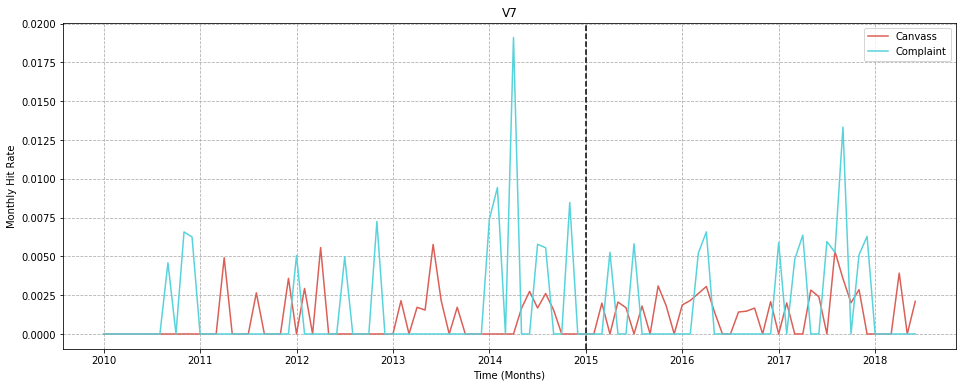

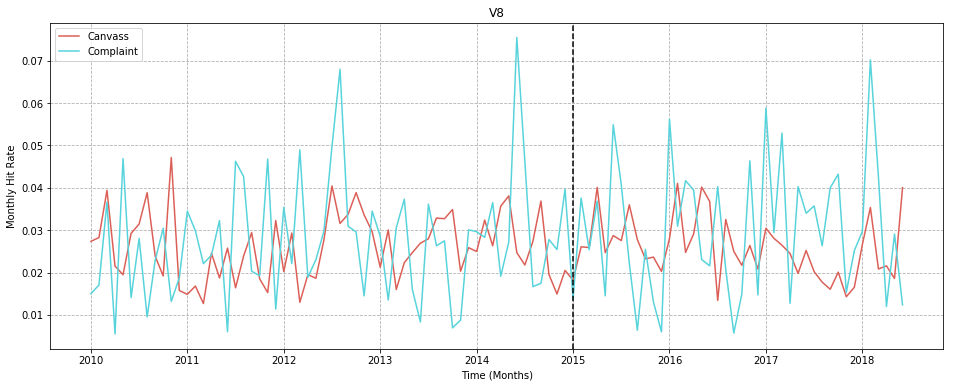

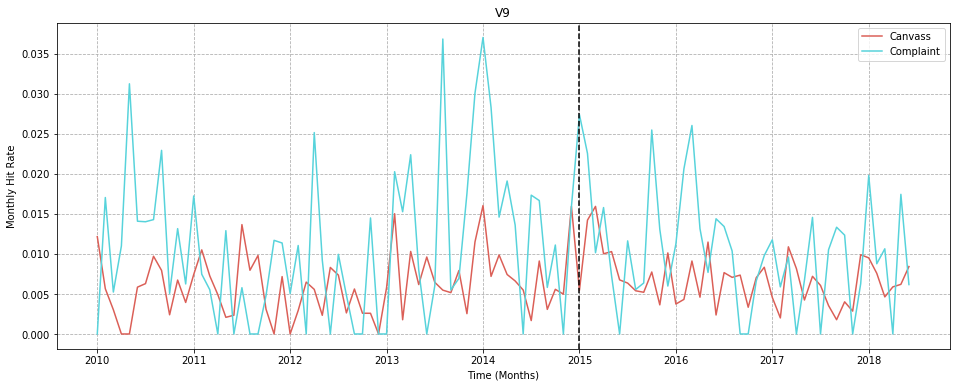

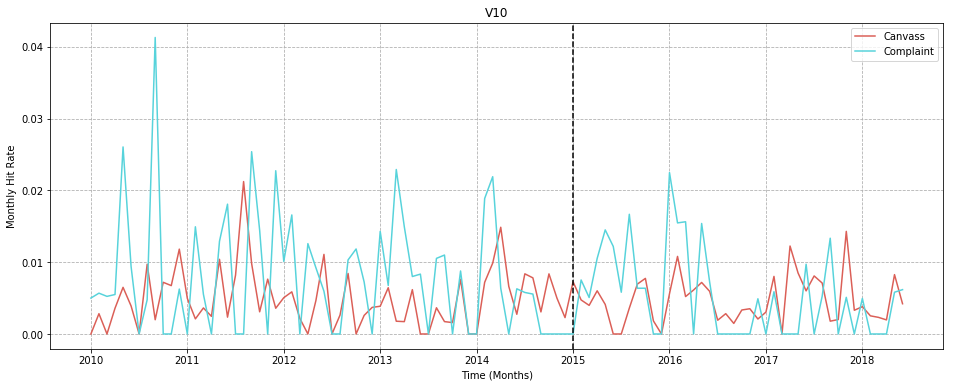

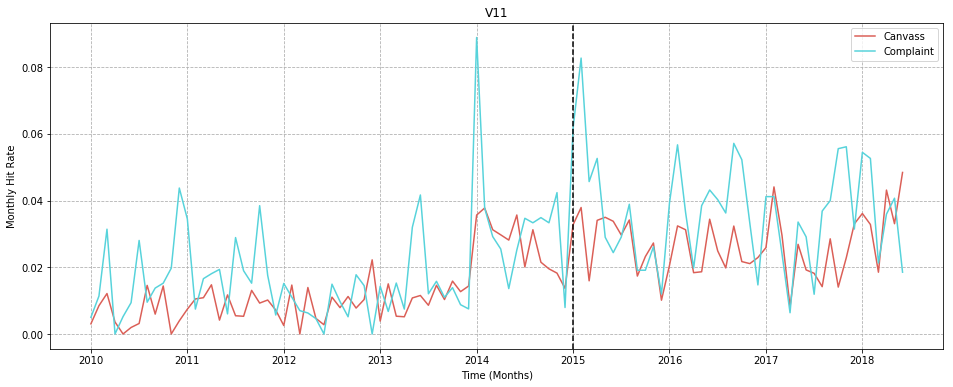

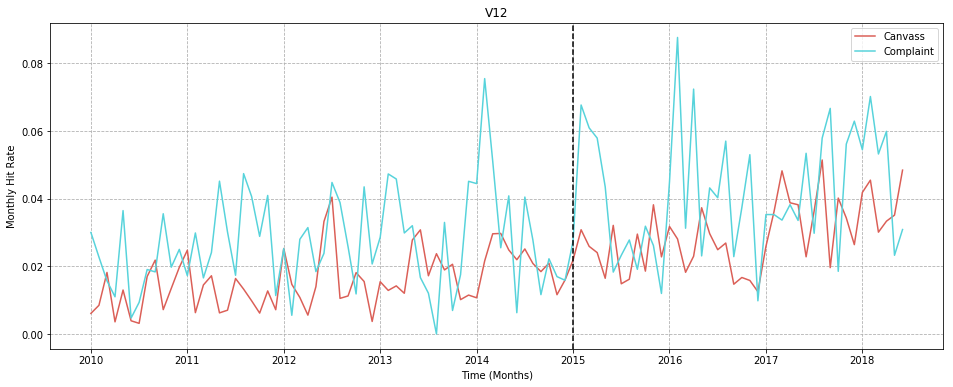

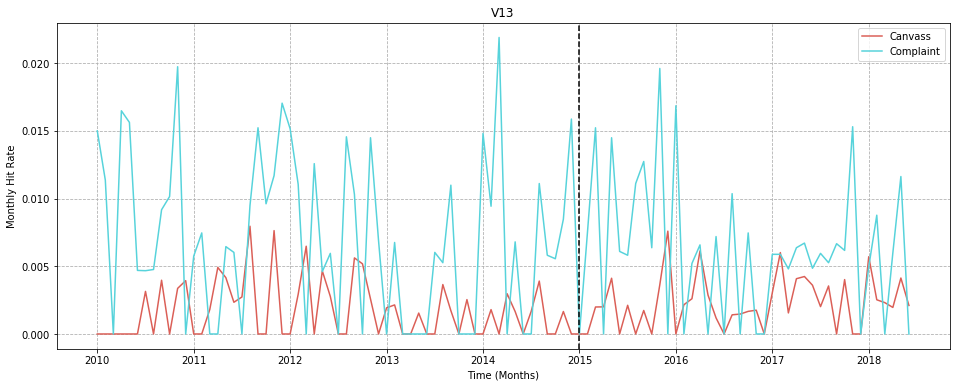

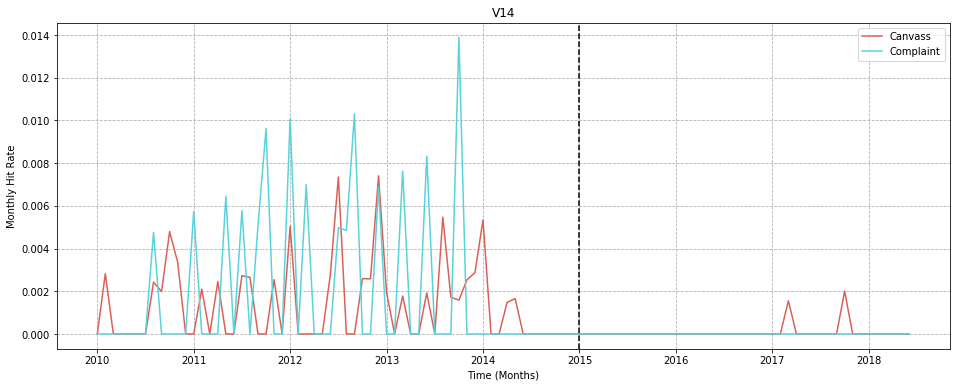

In [14]:
for viol in VIOLATIONS:
    show_hit_rate_lineplot(all_canvass, all_complaint, viol)